## Directories etc

In [179]:
from __future__ import division

import codecs
import csv
import os
import time
from os import listdir
from os.path import isfile, join
import re
import io


# Directory and file names:

# os.getcwd() replaces __file__ in Jupyter notebooks
dir_in = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "lemmatization", "input_TM"))
dir_out = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "files_years"))  # relative path to data directory
dir_hartlib = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "Hartlib Papers 2nd edition"))
#dir_hartlib = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "Hartlib Papers 2nd edition"))

# create output directory if it doesn't exist:
if not os.path.exists(dir_out):
    os.makedirs(dir_out)

    
num_topics = 40

## Get date from the files in Hartlib 2nd edition

In [180]:
file_year = {}
missing = list()
files_hartlib = [f for f in listdir(dir_hartlib) if isfile(join(dir_hartlib, f))]
for file in files_hartlib:   # for each file in the folder, we open hit and retrieve a date that is possible for us ([1][6][0-9]{2}).
    #print("file:" + file)
    text = open(os.path.join(dir_hartlib, file), 'r').readlines()
    i = 0
    for line in text:
        i += 1
        if i == 1:
            hit = re.search("[1][6][0-9]{2}",line) # We can't utilise the HTML because tags differ. Also, sometimes no true date but a guess (a full text)
        
            if hit:
                if hit.group(0) != "1000":
                    file_year[file[:-5]] = hit.group(0) # we remove ".html" and use that as dictionary key
            else :
                missing.append(file)

set_missing = set(missing)    

print("missing a date:")
print(len(set_missing))
#print(missing)        
print("letters with a date:")
print(len(file_year))
print("letters in the hartlib folder:")
print(len(files_hartlib))
#print(file_year)

missing a date:
1531
letters with a date:
3703
letters in the hartlib folder:
5234


## Getting the files in English to match them with the letters with a date

In [181]:
# We first recreate a list with the file ID, not the filename

files_in = [f for f in listdir(dir_in) if isfile(join(dir_in, f))]
print(len(files_in))
#files_in_no = list()

for file in files_in:  # this creates a list with the file ID, not the filename
    files_in_no.append(file[:-12])
#print(len(files_in_no))

# We then match

dico_en = dict()
liste_en_no_date = list()



#print(files_in_no)
#print("\n\n\n")
#print(missing)
z = 0
for chose in files_in_no:
    if chose in file_year:
        dico_en[chose] = file_year[chose]
        z = z+1


print(z)

for fichier in files_in_no:
    fichier = fichier+".html"
    if fichier in missing:
        liste_en_no_date.append(fichier)

print("english files with date:")
print(len(dico_en))
#print(dico_en)
print("english files with no date:")
print(len(liste_en_no_date))
#print(liste_en_no_date)

# here we check if the letters that don't have a date contain "reply", as sometimes the replies do contain a date

#print("dico EN: ",dico_en)

#x = 0

#for file in files_hartlib:
#    if file in liste_en_no_date:
#        fichier = open(dir_hartlib+"/"+file)
#        texte = fichier.readlines()
#        for line in texte:
#            if "reply to" in line:
#                print("oui "+file)
#                x = x+1
#print(x)



3070
9116
english files with date:
2279
english files with no date:
3164


# Using the results of LDA -- now using the second topic model, with stopwords
## We create dict_topic_year[filename] = [topic, year]  (might be useless as only one entry per file, recheck)

In [182]:
# this might be wrong as "several topics per file" !

#topics_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "TM_output", "40", "output_csv","DocsInTopics.csv")),"r")
topics_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "TM_output_2", "40", "output_csv","DocsInTopics.csv")),"r")
topics_csv = topics_csv.readlines()
print("Number of lines in the CSV: "+str(len(topics_csv)))

dict_topic_year = dict()

for line in topics_csv:
    line = line.rstrip()
    line = line.split(";")
    file_name = line[3]    # we retrieve the file name
    file_name = file_name[64:-12]  # we keep the ID and remove the path
    if file_name in file_year:
        dict_topic_year[file_name] = [line[0],file_year[file_name]]  # we update the dictionary with filename as key, topic and year as data

print("Number of entries in the dictionary :"+str(len(dict_topic_year)))        
#print(dict_topic_year)

Number of lines in the CSV: 20001
Number of entries in the dictionary :2038


## Using topicsindoc.csv, take all top topics and the files that pertain to them
### Also, given the time slices, we create topic_slice_files which maps (topic, slice) to the corresponding files

In [248]:
#topicsindocs_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "TM_output", "40", "output_csv","TopicsInDocs.csv")),"r")
topicsindocs_csv = open(os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), "OneDrive", "TM_output_2", "40", "output_csv","TopicsInDocs.csv")),"r")
topicsindocs_csv = topicsindocs_csv.readlines()[1:] # skip the first line (headers)
dict_file_topic = dict()
list_topics = list()
topic_slice_files = dict() # maps a (topic, time slice) to the corresponding list of files

# slices = [1610,1635,1650,1675]
slices = [1610,1650,1665] # now trying with two slices

topic_year_number = dict()

## dico_en is file_year for ENGLISH

liste_annee = list(dico_en.values())

liste_annee_liste = liste_annee
liste_annee = list(set(liste_annee)) # all different years for which we have a file
#print(liste_annee)

print("\n\nTime Range: "+str(sorted(liste_annee)[0])+" --> "+str(sorted(liste_annee)[len(liste_annee)-1]))
total_of_years = int(sorted(liste_annee)[len(liste_annee)-1])-int(sorted(liste_annee)[0])
print("total of years",total_of_years,"\n")

yearz = list()
for i in range(int(sorted(liste_annee)[0]),int(sorted(liste_annee)[len(liste_annee)-1])):  # this is just to get all dates
    yearz.append(i)
print(yearz)

annee_count = dict()
for annee in liste_annee:
    annee_count[annee] = 0

for i in range(0,40):
    list_topics.append(i)
    dict_file_topic[i] = 0
#    topic_year_number[i] = dict(annee_count)  # for each of the topic number we have a dictionary with the year as key
#    for annee in liste_annee: 
        


for line in topicsindocs_csv:  # we discriminate on FILES
    line = line.rstrip()
    line = line.split(";")
   # print(line)
    
#    print(line) isinstance(1,int)
        
        #print(topic_number)
    #    x = 0
    file_name_indocs = line[1]    # we retrieve the file name
    file_name_indocs = file_name_indocs[64:-12]  # we keep the ID and remove the path
    
    
    j = 0
    topics_this_line = list()
    for col in line: 
        #print(col)
            
        if j % 2 == 0 and j > 0:  # we need j is at least 2, and even to capture the columns with topics
            topic = col

            if topic != "":
                topics_this_line.append(topic)
            
        j += 1
    
    for topic_number in topics_this_line:
        #print(topic_number)
        if file_name_indocs in file_year:
            year = file_year[file_name_indocs]
           
        
        
            if (topic_number, year) in topic_year_number:  # this is for the count
                topic_year_number[(topic_number, year)] += 1
            
            if (topic_number, year) not in topic_year_number:  # this is for the count
                topic_year_number[(topic_number, year)] = 1
                
            
            for s in range(0,len(slices)-1):
                if int(year) > slices[s] and int(year) <= slices[s+1]:
                    if (str(topic_number),s) in topic_slice_files.keys():
                        topic_slice_files[(str(topic_number),s)].append(file_name_indocs)
                    else:                        
                        topic_slice_files[(str(topic_number),s)] = [file_name_indocs]
                        print("topic number ",str(topic_number),"slice ",str(s),file_name_indocs)
                
                            
                    
    
#print(topic_year_number)
#for (topic, year) in topic_year_number: 
    
#    une_annee = topic_year_number[topic, year] 
#    if une_annee >= 50:
#        print("topic",topic,"year",year,"nombre une_annee",une_annee)
        # this above prints the topics for which, at a given year, there are at least 50 files
        
       
    # topic_year_number{} (topic,year): numberoffiles

    
#print("number of entries in topic_year_number:",len(topic_year_number.keys()))
# average of 28 years per topic


#for t in range(0,40):  # for each topic 
#    print("\n\ntopic",t)
#    comptage = 0
#
    
#    for key in topic_year_number.keys():  # for every key
#        if int(key[0]) == t:  # if int(first item in key) is the t we're currently dealing with
    
#            for y in range(0,total_of_years):  # for all values y between 0 and the total numbers of years we have
#                comptage = 0
                       
#                cette_annee = (key[0],key[1])[1]  # storing, in cette_annee, the year for topic t  (iteration)
                


                #if (key[0],cette_annee) in topic_year_number:  # if the key exists
                 #   print(key[0],cette_annee,topic_year_number[(key[0],cette_annee)])
            
                # if this date matches one of the dates we have AND the entry exists
#                if int(cette_annee) == yearz[y] and (key[0],cette_annee) in topic_year_number:  
                  
#                    comptage = comptage + topic_year_number[(key[0],cette_annee)] # we count
#                    print(cette_annee,comptage)
               
                




Time Range: 1610 --> 1667
total of years 57 

[1610, 1611, 1612, 1613, 1614, 1615, 1616, 1617, 1618, 1619, 1620, 1621, 1622, 1623, 1624, 1625, 1626, 1627, 1628, 1629, 1630, 1631, 1632, 1633, 1634, 1635, 1636, 1637, 1638, 1639, 1640, 1641, 1642, 1643, 1644, 1645, 1646, 1647, 1648, 1649, 1650, 1651, 1652, 1653, 1654, 1655, 1656, 1657, 1658, 1659, 1660, 1661, 1662, 1663, 1664, 1665, 1666]
topic number  21 slice  1 8A_09
topic number  33 slice  1 8A_09
topic number  18 slice  1 8A_09
topic number  30 slice  1 8A_09
topic number  33 slice  0 34B_06_08
topic number  30 slice  0 34B_06_08
topic number  14 slice  0 34B_06_08
topic number  23 slice  0 34B_06_08
topic number  0 slice  0 14C_04_68
topic number  20 slice  0 14C_04_68
topic number  8 slice  0 14C_04_68
topic number  1 slice  0 14C_04_68
topic number  32 slice  0 14C_04_68
topic number  6 slice  0 14C_04_68
topic number  34 slice  0 60C_14_32
topic number  25 slice  0 60C_14_32
topic number  12 slice  0 9C_11_21
topic number  5 sl

In [250]:
print(len(topic_slice_files))
print(sorted(topic_slice_files[('0', 0)]))
#print(len(topic_slice_files[('0', 0)]))
#print(topic_slice_number['0', 0])

80
['10A_01_06', '11A_01_009', '11A_01_016', '11A_01_018', '11A_01_019', '11A_01_039', '11B_01_068', '11B_01_087', '11B_01_089', '11B_01_091', '11C_01_112', '11C_01_114', '11C_01_117', '13A_028', '13B_061', '13B_099', '14B_04_39', '14B_04_40', '14B_04_45', '14C_04_60', '14C_04_68', '14C_04_70', '15C_08_05', '18A_01_17', '20A_04_17', '23A_02_12', '23B_12', '23B_17', '27A_11_01', '27A_11_03', '27A_11_05', '2A_02_07', '2A_02_43', '2B_06_03', '2B_09_12', '2C_09_26', '2C_09_30', '2C_09_34', '33B_03_07', '33B_03_09', '3B_02_107', '42B_13_03', '42B_13_05', '43A_23', '44B_08', '45A_01_03', '45A_01_04', '45A_01_05', '46C_14_06', '47A_09_34', '4A_01_21', '4A_01_22', '4A_01_31', '5B_16_01', '5C_37', '5D_44', '6B_04_135', '6B_04_139', '6B_04_143', '6B_04_151', '7F_113']
61


## Defining time slices
Getting for each topic the number of files per time slice

In [251]:
print(topic_year_number)

{('33', '1660'): 4, ('18', '1643'): 3, ('0', '1639'): 4, ('24', '1656'): 1, ('8', '1630'): 2, ('17', '1649'): 12, ('20', '1645'): 9, ('20', '1658'): 12, ('26', '1655'): 15, ('15', '1654'): 3, ('8', '1638'): 7, ('25', '1651'): 1, ('15', '1642'): 13, ('29', '1646'): 28, ('15', '1658'): 19, ('30', '1651'): 7, ('15', '1645'): 6, ('19', '1611'): 1, ('20', '1652'): 1, ('1', '1648'): 41, ('2', '1637'): 6, ('1', '1630'): 6, ('11', '1659'): 9, ('33', '1657'): 13, ('11', '1651'): 2, ('36', '1659'): 13, ('11', '1648'): 9, ('18', '1654'): 8, ('8', '1633'): 5, ('7', '1655'): 1, ('34', '1655'): 23, ('14', '1631'): 10, ('5', '1661'): 19, ('23', '1656'): 8, ('39', '1634'): 1, ('31', '1658'): 7, ('27', '1631'): 1, ('38', '1648'): 1, ('26', '1643'): 10, ('31', '1659'): 6, ('6', '1650'): 2, ('37', '1641'): 23, ('9', '1646'): 1, ('27', '1654'): 11, ('39', '1648'): 6, ('22', '1655'): 3, ('5', '1644'): 46, ('26', '1653'): 2, ('3', '1636'): 3, ('34', '1624'): 1, ('12', '1641'): 6, ('34', '1630'): 2, ('13', '

topic_slice_number = dict() #maps a (topic, time slice) to the corresponding number of files



for topic in range(40):  # for each topic
    topic = str(topic)
    print("\ntopic:",topic)
    for i in range(0,len(slices)-1): # for each of the slices
        print("slice number:", i)
    

        topic_slice_number[(topic, i)] = 0

        for x in range(slices[i],slices[i+1]):
            #print(x)
            x = str(x)
            if (topic,x) in topic_year_number:
                #print(topic_year_number[(topic,x)])
                topic_slice_number[(topic, i)] += topic_year_number[(topic,x)]
                                              
                # todo here append file names to topic_slice_files
                
        
        if topic_slice_number[(topic, i)] != 0:
            print(topic_slice_number[(topic, i)])
#topic_slice_number[('0',1)]            

In [252]:
topic_abc = dict()
for (t,s) in topic_slice_files:
    topic_abc[(t,s)] = len(topic_slice_files[(t,s)])

print(topic_abc[('0',0)])

61


## Copy the files to their corresponding folders slice/topic 


In [296]:
#print(topic_slice_files)

In [255]:
number_files_slices = list()
total_number_files = 0

for i in range(0,len(slices)-1):
    number_files_slices.append(0)

)

for topic in range(0,num_topics):
    topic = str(topic)
    for i in range(0,len(slices)):
        if (topic,i) in topic_slice_files:
            for filename in topic_slice_files[(topic,i)]:
                source = dir_in+"/"+filename+"_cleaned.txt"
                destination_folder = "Topics_by_slices_2/slice_"+str(i)+"/"+str(topic)+"/"
                destination_slice_folder = "Topics_by_slices_2/slice_"+str(i)+"/"+"_all_files/"
                destination = "Topics_by_slices_2/slice_"+str(i)+"/"+str(topic)+"/"+filename+"_cleaned.txt"
                destination_slice = "Topics_by_slices_2/slice_"+str(i)+"/"+"_all_files/"+filename+"_cleaned.txt"

                if not os.path.exists(destination_folder):
                    os.makedirs(destination_folder)


                if not os.path.exists(destination_slice_folder):
                    os.makedirs(destination_slice_folder)

                copyfile(source, destination)  # file is in a slice/topic folder to which it pertains
                copyfile(source, destination_slice) # file is in a "all files in this slice" folder. Removes duplicates

                total_number_files += 1
                number_files_slices[i] += 1


print("number of files moved",str(total_number_files))
print(number_files_slices)
#print(len(topic_slice_files[('6', 2)]))

number of files moved 9091
[5347, 3744]


In [297]:
#print(len(topic_slice_files['0',1]))
#print(sorted(topic_slice_files['0',1]))

#print(topic_abc[('0',1)])

In [314]:
# List of labels for the topics. Manually created by Robin
# this is hardcoded for now, next step is reading a file

topic_labels = ["newsletters about politics", 
               "friendship", 
               "religion: spirituality/faith", 
               "religion: church life", 
               "religious war/peace", 
               "Underspecified_actions",
               "letter writing/copying", 
               "trade of agricultural produce/plantations",
               "advancement of learning for the public good",
               "spirituality/dreams",
               "making cider/horticulture",
               "alchemy",
               "visiting/travelling",
               "poverty/charity(?)",
               "(writing) books/manuscripts",
               "personal relationships",
               "medicine: medicinal herbs",
               "education, learning languages",
               "medicine: (iatro) chemical experiments",
               "Office of Address (public office for jobs/knowledge)",
               "army/military/troop movement",
               "making an engine (water/manure)/technology/inventions",
               "Underspecified_colonies/settlers",
               "fear and hope",
               "plans for innovations in fishing presented to Parliament",
               "garbage topic",
               "war/peace between nations",
               "agriculture",
               "religion: morality/sin",
               "knowledge",
               "letter writing/sending",
               "law",
               "religion: fear and hope",
               "horticulture/husbandry",
               "academic life/publishing of academic books",
               "natural philosophy (physics)",
               "money/selling and buying",
               "religion: church/charity",
               "religion: theology/doctrine",
               "writing/editing (more about books than letters)"]
print(topic_labels)


['newsletters about politics', 'friendship', 'religion: spirituality/faith', 'religion: church life', 'religious war/peace', 'Underspecified_actions', 'letter writing/copying', 'trade of agricultural produce/plantations', 'advancement of learning for the public good', 'spirituality/dreams', 'making cider/horticulture', 'alchemy', 'visiting/travelling', 'poverty/charity(?)', '(writing) books/manuscripts', 'personal relationships', 'medicine: medicinal herbs', 'education, learning languages', 'medicine: (iatro) chemical experiments', 'Office of Address (public office for jobs/knowledge)', 'army/military/troop movement', 'making an engine (water/manure)/technology/inventions', 'Underspecified_colonies/settlers', 'fear and hope', 'plans for innovations in fishing presented to Parliament', 'garbage topic', 'war/peace between nations', 'agriculture', 'religion: morality/sin', 'knowledge', 'letter writing/sending', 'law', 'religion: fear and hope', 'horticulture/husbandry', 'academic life/pub

## Visualising the number of files per topic per slice

0 [11.40826631756125, 26.976495726495727]
1 [80.60594726014588, 75.85470085470085]
2 [24.499719468861045, 17.628205128205128]
3 [13.278473910604077, 6.677350427350428]
4 [30.29736300729381, 25.373931623931625]
5 [72.37703385075743, 50.48076923076923]
6 [71.06788853562746, 53.68589743589744]
7 [14.213577707125491, 17.36111111111111]
8 [46.38114830746213, 20.833333333333332]
9 [4.67551898260707, 30.715811965811966]
10 [1.8702075930428277, 23.504273504273506]
11 [5.049560501215635, 14.423076923076923]
12 [22.068449597905367, 16.826923076923077]
13 [11.034224798952684, 8.012820512820513]
14 [15.335702262951187, 6.677350427350428]
15 [18.88909668973256, 22.168803418803417]
16 [8.228913409388442, 26.70940170940171]
17 [17.018889096689733, 18.696581196581196]
18 [7.854871890779877, 24.83974358974359]
19 [21.320366560688235, 33.92094017094017]
20 [21.133345801383953, 12.820512820512821]


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


21 [14.961660744342621, 21.634615384615383]
22 [20.94632504207967, 20.566239316239315]
23 [35.34692350850944, 11.485042735042734]
24 [10.09912100243127, 5.608974358974359]
25 [7.293809612867029, 8.814102564102564]
26 [21.694408079296803, 28.311965811965813]
27 [7.293809612867029, 34.98931623931624]
28 [13.46549466990836, 10.149572649572649]
29 [28.053113895642415, 17.36111111111111]
30 [101.17823078361698, 110.84401709401709]
31 [18.32803441181971, 13.087606837606838]
32 [39.274359453899386, 40.33119658119658]
33 [6.919768094258463, 18.696581196581196]
34 [33.6637366747709, 43.26923076923077]
35 [8.78997568730129, 21.367521367521366]
36 [20.75930428277539, 21.10042735042735]
37 [64.89620347858612, 17.36111111111111]
38 [11.221245558256966, 5.3418803418803416]
39 [17.205909855994015, 15.491452991452991]


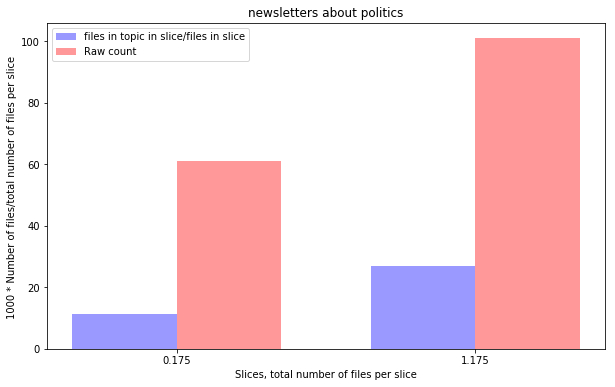

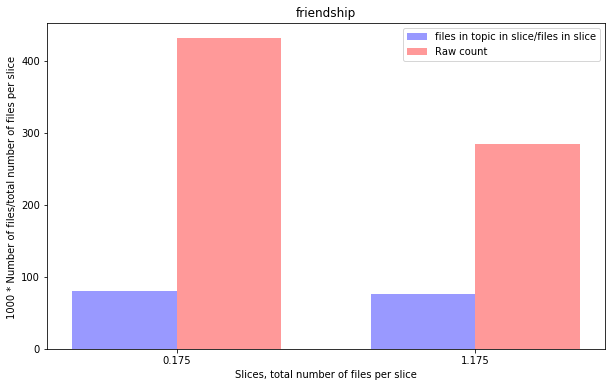

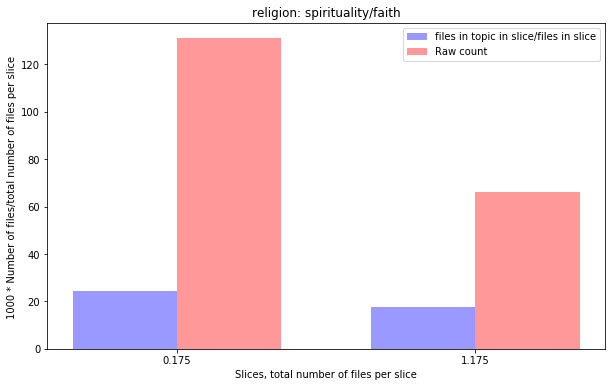

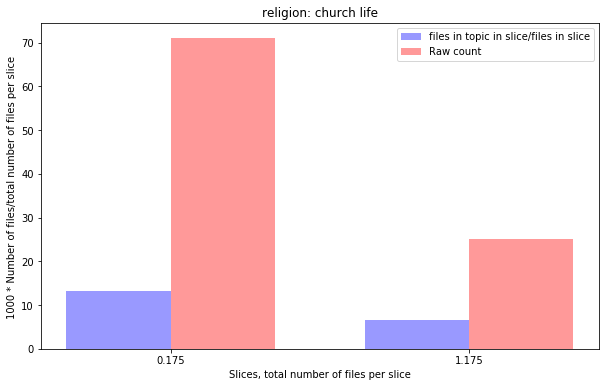

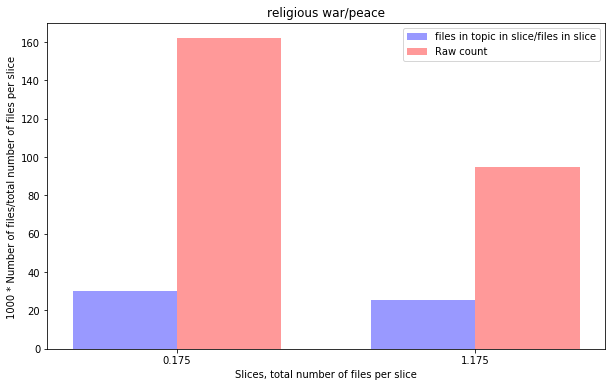

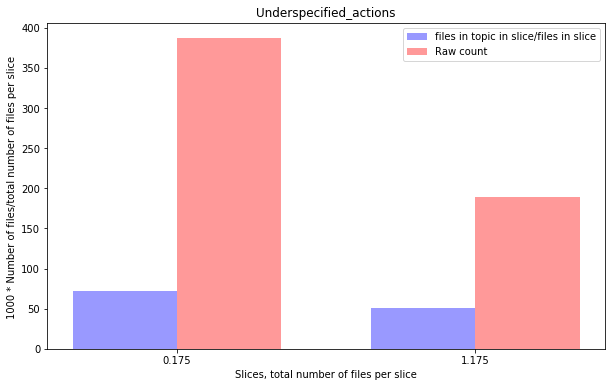

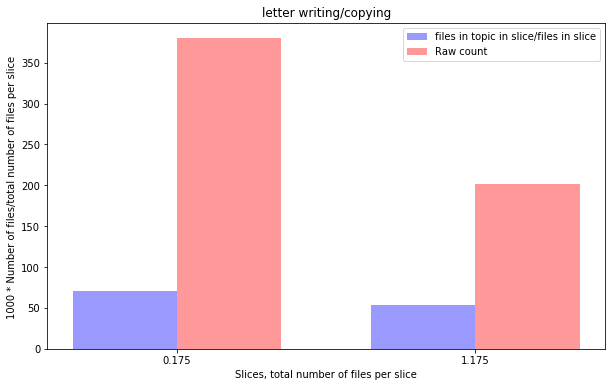

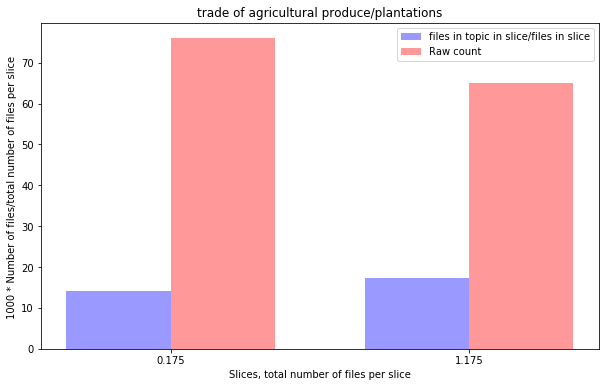

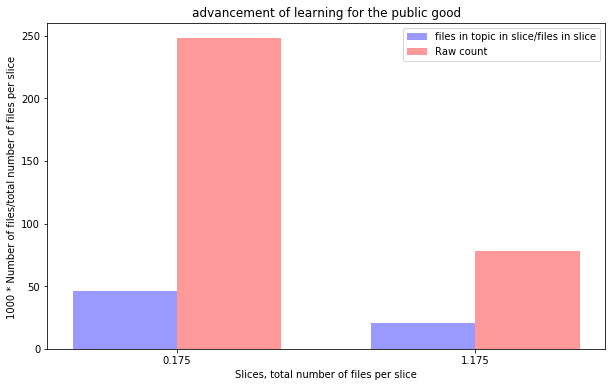

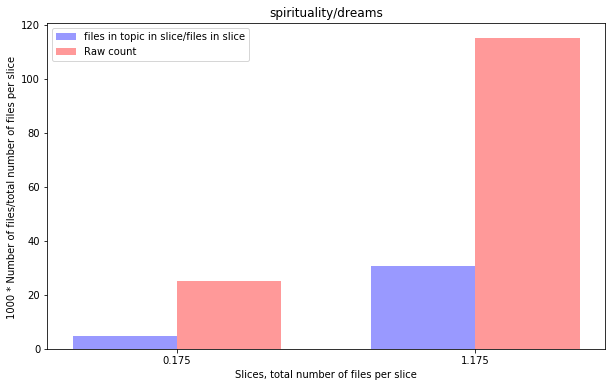

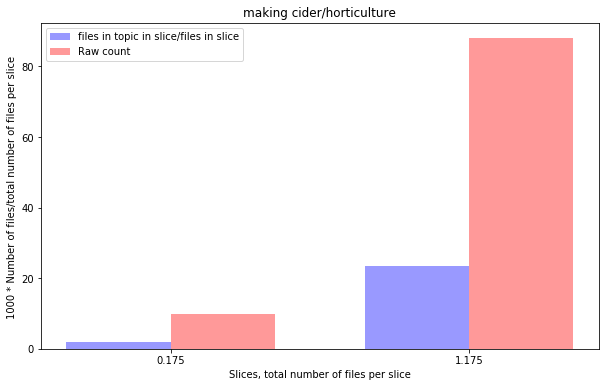

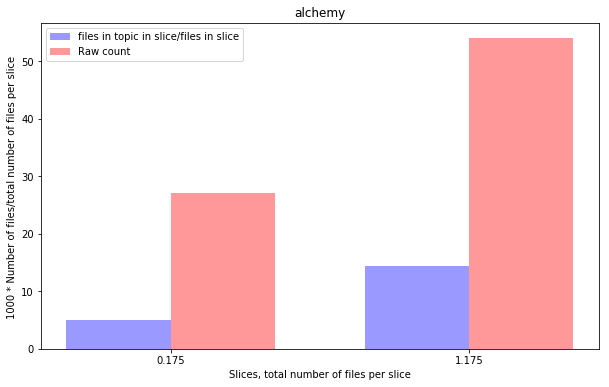

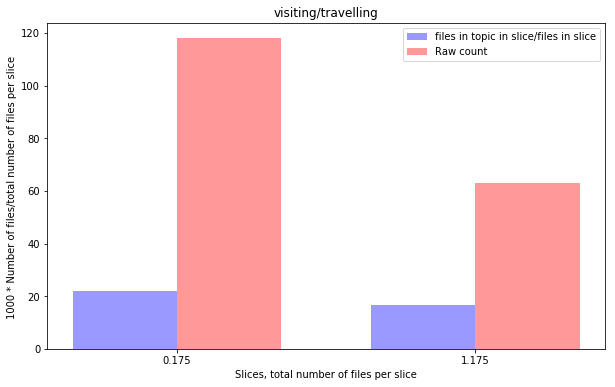

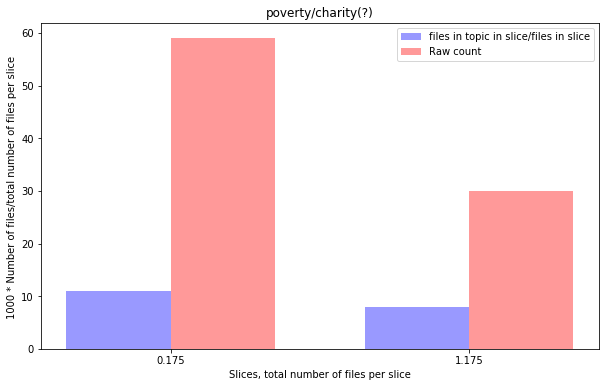

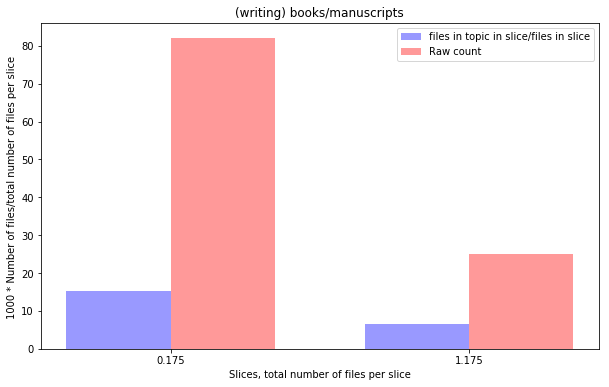

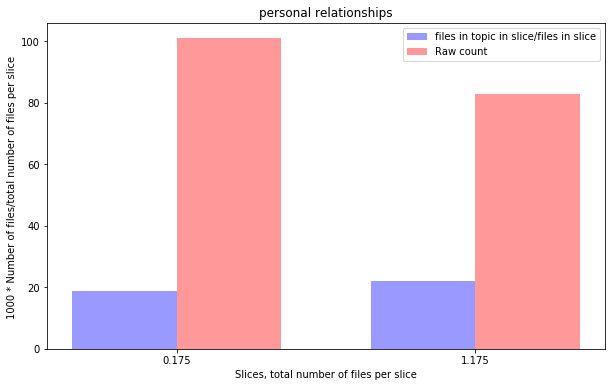

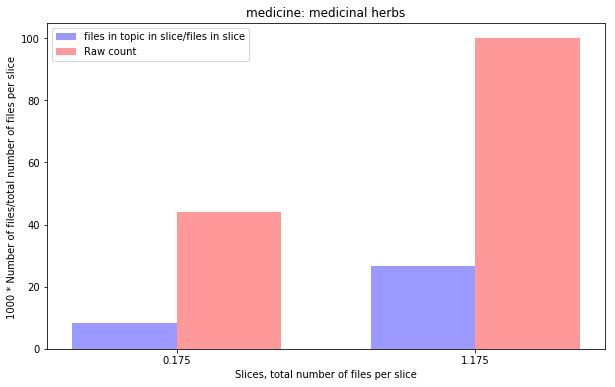

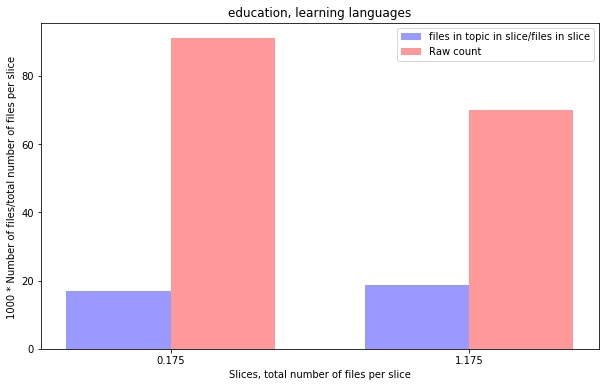

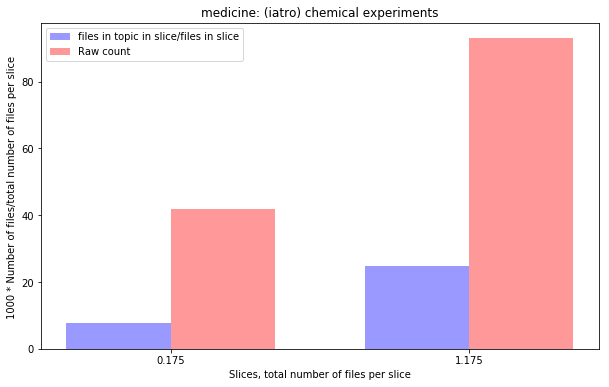

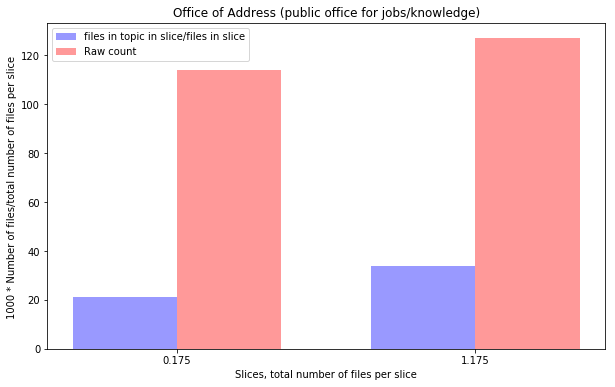

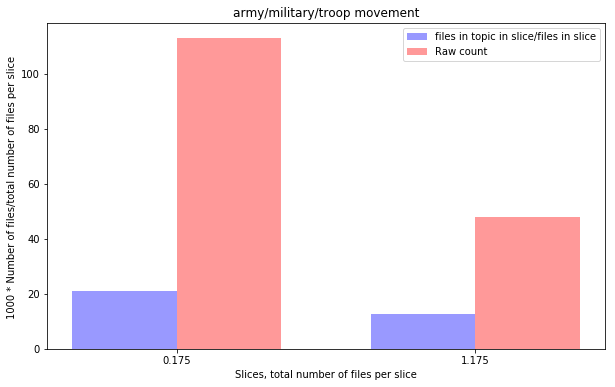

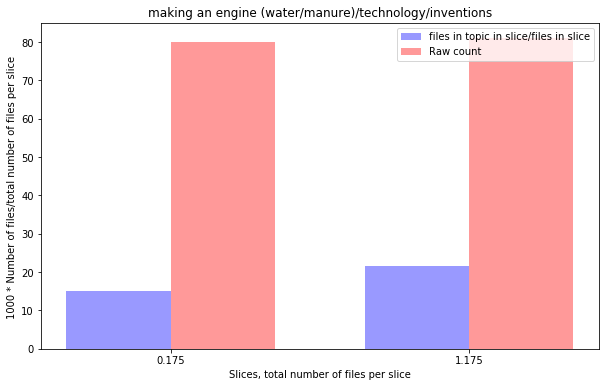

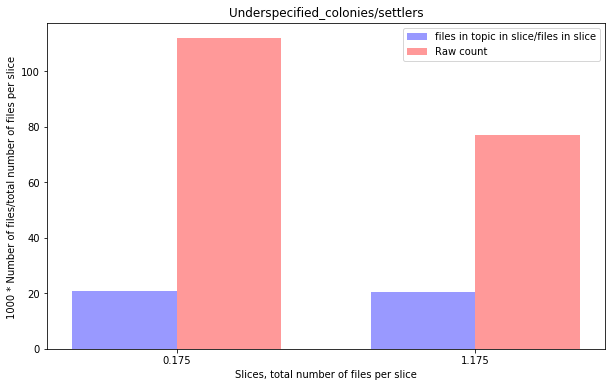

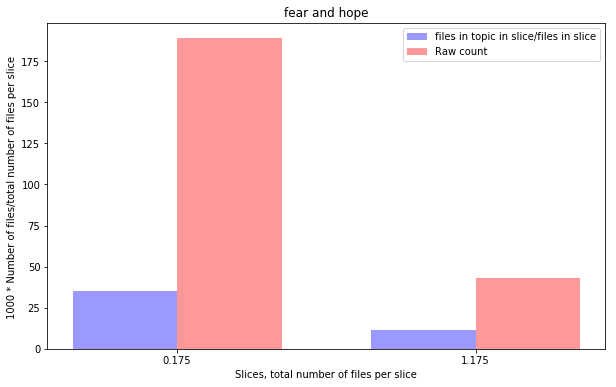

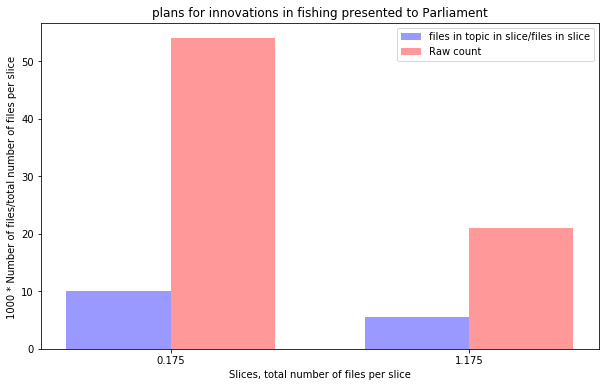

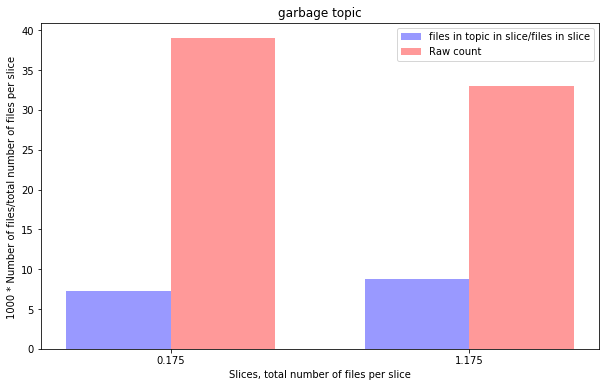

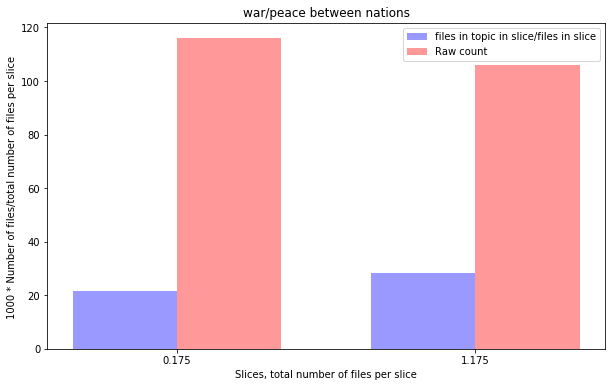

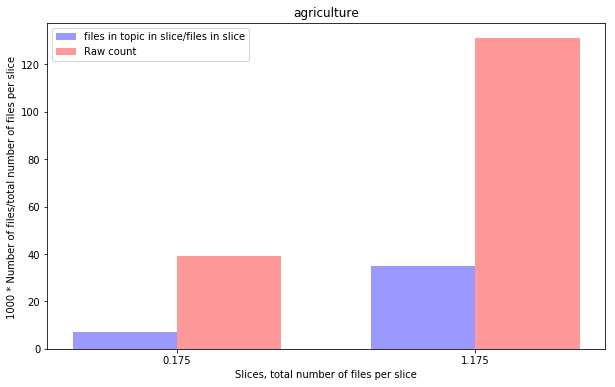

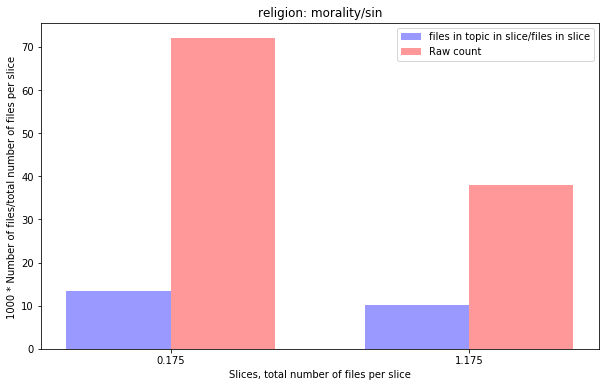

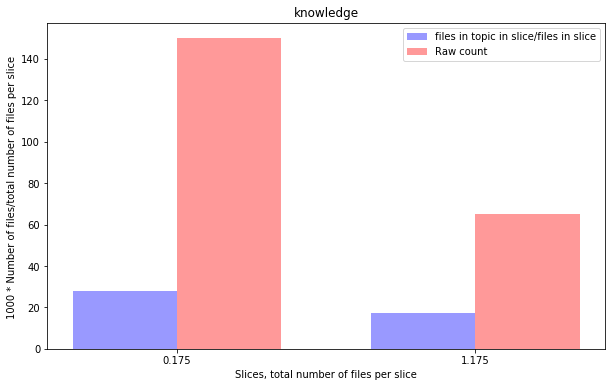

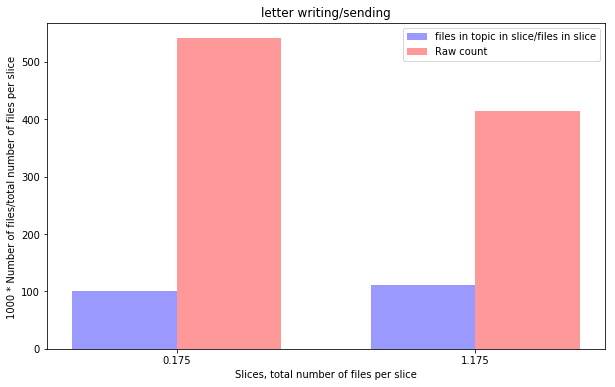

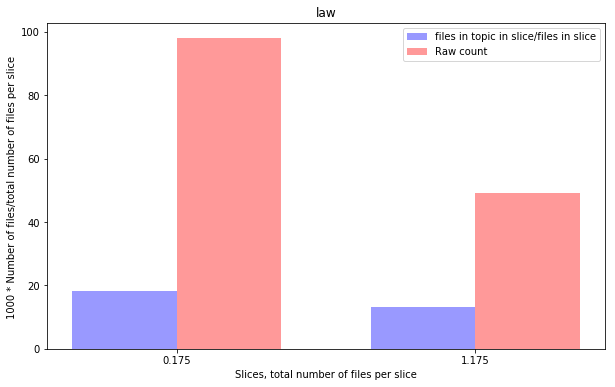

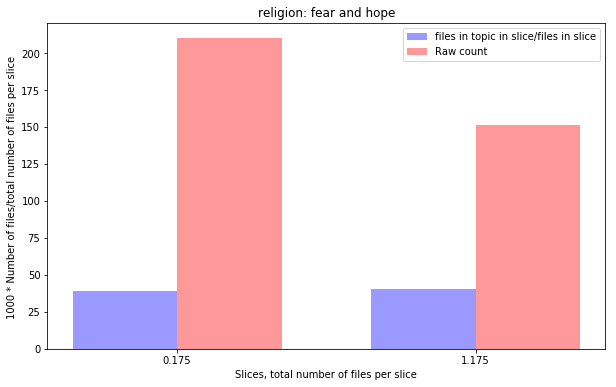

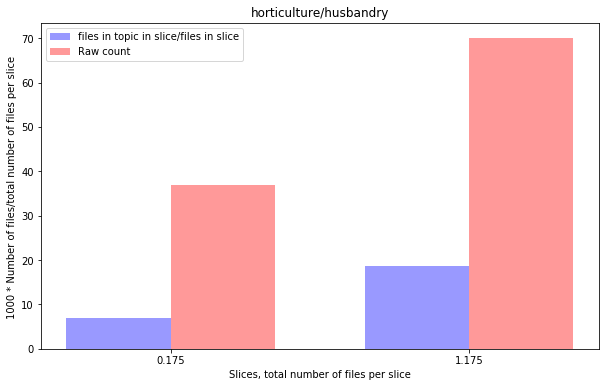

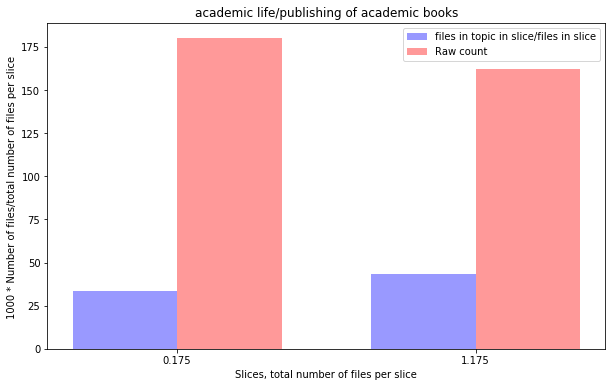

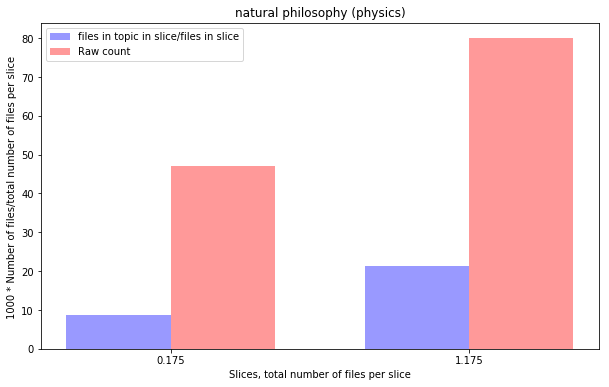

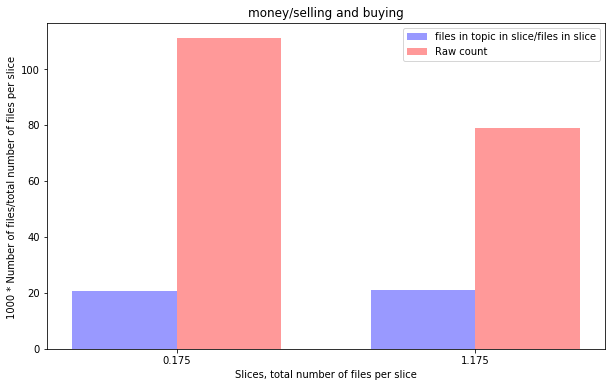

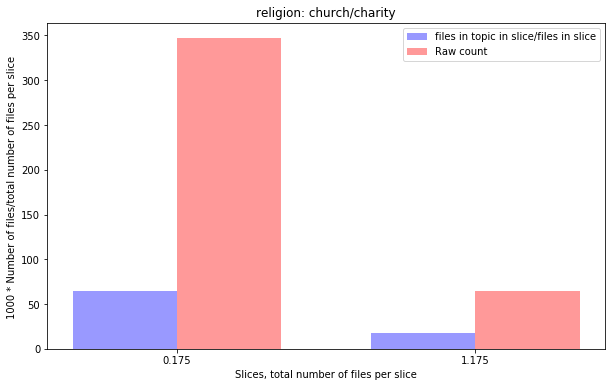

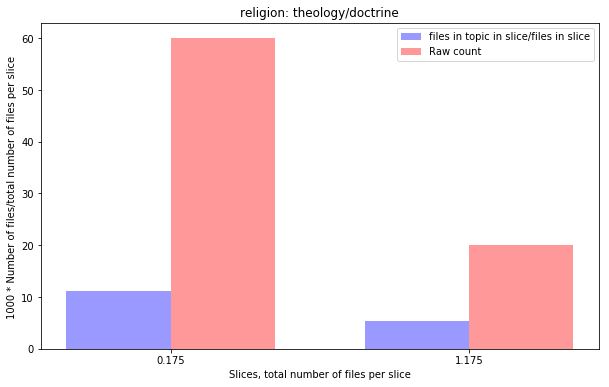

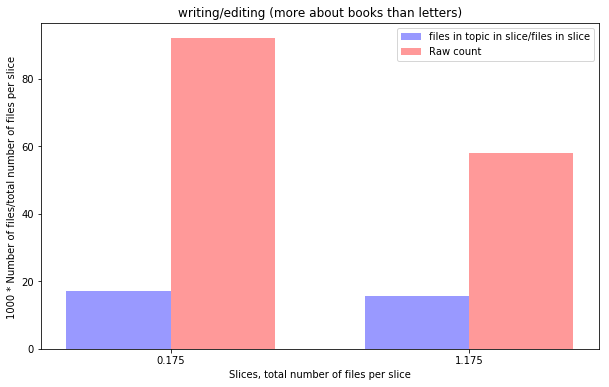

{('9', 1): 115, ('5', 0): 387, ('32', 0): 210, ('18', 1): 93, ('30', 1): 415, ('8', 1): 78, ('35', 0): 47, ('19', 1): 127, ('39', 1): 58, ('38', 1): 20, ('39', 0): 92, ('28', 1): 38, ('4', 0): 162, ('34', 0): 180, ('25', 1): 33, ('1', 1): 284, ('13', 1): 30, ('24', 1): 21, ('33', 1): 70, ('31', 0): 98, ('26', 1): 106, ('32', 1): 151, ('21', 1): 81, ('2', 1): 66, ('30', 0): 541, ('35', 1): 80, ('3', 1): 25, ('16', 0): 44, ('23', 0): 189, ('11', 1): 54, ('28', 0): 72, ('20', 0): 113, ('17', 0): 91, ('1', 0): 431, ('13', 0): 59, ('0', 1): 101, ('27', 1): 131, ('36', 0): 111, ('22', 1): 77, ('26', 0): 116, ('15', 0): 101, ('21', 0): 80, ('7', 1): 65, ('2', 0): 131, ('10', 0): 10, ('3', 0): 71, ('11', 0): 27, ('17', 1): 70, ('25', 0): 39, ('20', 1): 48, ('12', 1): 63, ('23', 1): 43, ('6', 0): 380, ('27', 0): 39, ('14', 1): 25, ('36', 1): 79, ('29', 1): 65, ('9', 0): 25, ('15', 1): 83, ('37', 0): 347, ('7', 0): 76, ('31', 1): 49, ('10', 1): 88, ('18', 0): 42, ('5', 1): 189, ('0', 0): 61, ('8

In [299]:
import pylab
import numpy as np
from array import array
import matplotlib.pyplot as plt


pylab.rcParams['figure.figsize'] = (10, 6) # this is for bigger figures

n_groups = len(slices)-1  # the number of bars we'll have, i.e the number of slices


for t in range(0,num_topics):
    
    bars = list()
    bar_width = 0.35
    bars_raw = list()

    
    
    
    for i in range(0,n_groups):

        if (str(t),i) in topic_abc:
    
            bars.append(1000*topic_abc[(str(t),i)]/number_files_slices[i])
            # number_files_slices[i] is the total number of files for slice i, with duplicates (one file in several topics)
            bars_raw.append(topic_abc[(str(t),i)])


        else:
            bars.append(0) # In case we don't have anything, we store a zero

        
        
    print(t,bars)
    fig, ax = plt.subplots()

    index = np.arange(n_groups)

    opacity = 0.4
    error_config = {'ecolor': '0.3'}

    rects1 = plt.bar(index, bars, bar_width,
                     alpha=opacity,
                     color='b',
                      #  yerr=std_men,
                     error_kw=error_config,
                     label='files in topic in slice/files in slice')
    
    rects2 = plt.bar(index + bar_width, bars_raw, bar_width,
                 alpha=opacity,
                 color='r',
                 #yerr=std_women,
                 error_kw=error_config,
                 label='Raw count')
                     
    plt.xlabel('Slices, total number of files per slice')
    plt.ylabel('1000 * Number of files/total number of files per slice ')
    plt.title(topic_labels[t])
    #plt.xticks(index + bar_width / 2, (str(slices[i])+' to '+str(slices[i+1]), str(slices[1])+' to '+str(slices[2]), str(slices[2]) +' to' +str(slices[3])))
    plt.xticks(index + bar_width / 2)

    plt.legend()


    plt.savefig("Topic "+str(t)+".png")

plt.show()
plt.gcf().clear()
print(topic_abc)
#plt.bar(list(topic_slice_number.keys()), dict_file_topic.values(), color='g')
#plt.title("Number of files per topic")
#plt.show()


## comment on "files in topic in slice / files in slice" :
### we do the division on the duplicates and not on the exact number of files (as one file is in several topics)

In [260]:
#print(topic_abc[('0', 0)])

#print(topic_year_number)

61


In [313]:
threshold_of_files = 50 # this number is decided by us. Min number of files per topic in both slice

topic_threshold = list()

for t in range(0,num_topics):
   
    
    for i in range(0,n_groups):

        if (str(t),i) in topic_abc and (str(t),i+1) in topic_abc :
            if topic_abc[(str(t),i)] >= threshold_of_files and topic_abc[(str(t),i+1)] >= threshold_of_files:
                #print("topic, number of files for which both slices have more than threshold_of_files files:\n"+str(t),topic_abc[(str(t),i)],topic_abc[(str(t),i+1)])
                topic_threshold.append(t) 

print(topic_threshold)   
print(len(topic_threshold))

                
for topic in topic_threshold:
    print(topic,topic_labels[topic])


[0, 1, 2, 4, 5, 6, 7, 8, 12, 15, 17, 19, 21, 22, 26, 29, 30, 32, 34, 36, 37, 39]
22
0 newsletters about politics
1 friendship
2 religion: spirituality/faith
4 religious war/peace
5 Underspecified_actions
6 letter writing/copying
7 trade of agricultural produce/plantations
8 advancement of learning for the public good
12 visiting/travelling
15 personal relationships
17 education, learning languages
19 Office of Address (public office for jobs/knowledge)
21 making an engine (water/manure)/technology/inventions
22 Underspecified_colonies/settlers
26 war/peace between nations
29 knowledge
30 letter writing/sending
32 religion: fear and hope
34 academic life/publishing of academic books
36 money/selling and buying
37 religion: church/charity
39 writing/editing (more about books than letters)


## todo

- [x] two slices

- [x] filter correct years 
- [x] testing topic slice number
- [x] retrieve files pertaining to topics in different time slices 
- [x] visualisation -> will show what topics appeared and disappeared (account for number of files)

- [ ] run LDA with k = 1 on the slices for each of the 20 topics -- top words = 100, and we check the top 10 for changes

- [ ] for every topic find the difference between the words in slice 1 and the words in slice 2 for that topic
- [ ] consider trends in topic when interpreting results


- [x] normalise the number of letters per time slice (--> normalise number of files by all the files in that time slice) /_\ WE NEED CONFIDENCE INTERVAL
- [ ] optional: visualise the topic freq by time slice (+ find heuristic for "interesting trend", eg one slice is greater or equal than the sum of the two others)